# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

%matplotlib inline

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [3]:
data.shape

(200, 8)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [5]:
data.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


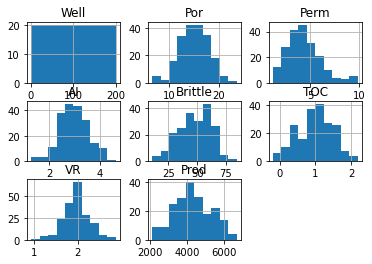

In [6]:
data.hist(); # изучаем распределение признаков и видим, что по всем признакам, кроме 'Well' распределение нормально

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [7]:
data.corr()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


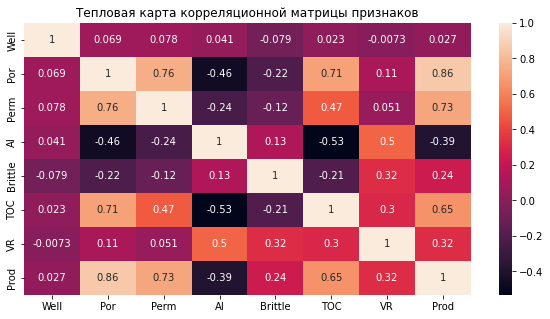

In [8]:
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(data.corr(), annot=True)
heatmap.set_title('Тепловая карта корреляционной матрицы признаков');

In [9]:
print(np.linalg.matrix_rank(data.corr()), round(np.linalg.det(data.corr()), 4))

8 0.0007


Выводы:

1. По графику видно, что сильнее всего с целевой переменной коррелируют признаки 'Por' и 'Perm'. 
2. Корреляционная матрица является плохо обусловенной, поскольку её опредитель близок к нулю.
3. Мультиколлинеарность среди признаков не наблюдается, значения коллинеарности только по двум парам признаков слегка превышают 0.7. Признак, который участвует в обеих парах - это признак 'Por', с другой стороны этот признак также имеет высокую линейную связь с целевым признаком - 0.86.
4. Исходя из вышеизложенного, модель классической линейной регрессии по методу наименьших квадратов в данном случае применима, поскольку ранг корреляционной матрицы максимален, а мультиколлинеарность отсутствует; делитель матрицы не слишком далёк от нуля, но и не слишком близок к нему.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [10]:
X = np.column_stack((np.ones(200), data.drop('Prod', axis=1)))
y = data['Prod']

ols_array = np.linalg.inv(X.T@X)@X.T@y

np.round(ols_array)

array([-1232.,     0.,   230.,   116.,  -365.,    25.,   -78.,   785.])

Выводы:

1. Судя по получившимся коэффициентам, наименьшее влияние на целевую переменную оказывает признак 'Well', поскольку его коэффициент равен нулю. Но эту модель линейной регрессии мы построили на нестандартизованных данных, поэтому этот вывод может быть ошибочным.
2. Самое большое влияние на целевую переменную, по нашим данным, оказывает нулевой коэффициент, он равен - 1 232. Это влияние обратно пропорционально. Самое большое прямо пропорциональное влияние на целевую переменную оказывает признак 'VR'.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [11]:
predict_dict = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }

prediction = ols_array[0] + ols_array[1]*predict_dict['Well'] + ols_array[2]*predict_dict['Por'] + ols_array[3]*predict_dict['Perm'] + ols_array[4]*predict_dict['AI'] + ols_array[5]*predict_dict['Brittle'] + ols_array[6]*predict_dict['TOC'] + ols_array[7]*predict_dict['VR']
print(round(abs(4748.315024 - prediction), 6))
y_predict = X@ols_array # считаем прогноз на трейне
print(round(metrics.mean_absolute_error(y, y_predict), 6))
print(round(metrics.mean_absolute_percentage_error(y, y_predict)*100, 2))
print(round(metrics.r2_score(y, y_predict), 4))

25.25097
153.622971
3.63
0.9599


Выводы:

1. Для новых данных наша модель предсказала ошибку всего в 25 футов на 4 748 футах.
2. Для оценки качества модели я выбрал метрики MAE, MAPE и R2. Метрика MAE на трейне показывает ошибку в 153 фута, MAPE - в 3%, а R2 - 0.9599, что говорит об очень неплохом качестве нашей модели.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [12]:
print(np.round(ols_array))
data.corr()

[-1232.     0.   230.   116.  -365.    25.   -78.   785.]


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


Выводы:

1. В нашей модели есть признак, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции, этот признак - 'TOC'. Корреляция говорит, что зависимость между признаком и целевой переменной прямая, а модель говорит обратное.
2. Полученное противоречие результатов может быть связано с тем, что наши данные нестандартизованы. 

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [13]:
data.drop(['TOC', 'Well'], axis=1).corr()

,Por,Perm,AI,Brittle,VR,Prod
Por,1.000000,0.760546,-0.461549,-0.218570,0.111860,0.861910
Perm,0.760546,1.000000,-0.239636,-0.124017,0.051023,0.727426
AI,-0.461549,-0.239636,1.000000,0.127599,0.499143,-0.390835
Brittle,-0.218570,-0.124017,0.127599,1.000000,0.317929,0.237155
VR,0.111860,0.051023,0.499143,0.317929,1.000000,0.323182
Prod,0.861910,0.727426,-0.390835,0.237155,0.323182,1.000000


In [14]:
X = np.column_stack((np.ones(200), data.drop(['Prod', 'TOC', 'Well'], axis=1)))

ols_array = np.linalg.inv(X.T@X)@X.T@y

print(np.round(ols_array))
y_predict = X@ols_array
print(round(metrics.mean_absolute_error(y, y_predict), 6))
print(round(metrics.mean_absolute_percentage_error(y, y_predict)*100, 2))
print(round(metrics.r2_score(y, y_predict), 4))

[-1293.   230.   113.  -309.    26.   683.]
153.923089
3.63
0.9597


Выводы:

1. Судя по получившимся коэффициентам, наименьшее влияние на целевую переменную оказывает признак 'Brittle', поскольку его коэффициент меньше остальных. Но эту модель линейной регрессии мы построили на нестандартизованных данных, поэтому этот вывод может быть ошибочным.
2. Самое большое влияние на целевую переменную по нашим данным оказывает также нулевой коэффициент, он равен - 1 293, и его значение ещё немного подросло после удаления двух признаков. Это влияние обратно пропорционально. Самое большое прямо пропорциональное влияние на целевую переменную также оказывает признак 'VR'.
3. Наша целевые метрики незначительно снизились по сравнению с полным набором данных, это говорит о том, что удалением двух признаков нам удалось значительно не ухудшить качество нашей модели.
4. Нам удалось побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции путём удаления признака, вызывавшего такое противоречие.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [15]:
model = LinearRegression()

model.fit(X, y)

print(np.round(model.coef_))
y_predict = model.predict(X)
print(round(metrics.mean_absolute_error(y, y_predict), 6))
print(round(metrics.mean_absolute_percentage_error(y, y_predict)*100, 2))
print(round(metrics.r2_score(y, y_predict), 4))

[   0.  230.  113. -309.   26.  683.]
153.923089
3.63
0.9597


In [16]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100)) 

MAPE на тренировочных фолдах: 3.62 %
MAPE на валидационных фолдах: 3.83 %


Выводы: 

1. По всем признакам с помощью библиотеки sklearn мы получили точно такие же коэффициенты, как и вручную. Значительную разницу имеет лишь коэффициент свободного члена, который вручную получился - 1 293, а с помощью библиотеки - 0. В чём причина такого расхождения, нам лишь предстоит узнать...

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [17]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_scaled_poly = poly.fit_transform(X)

print(X_scaled_poly.shape[1])

model = LinearRegression()

cv_results = cross_validate(model, X_scaled_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100)) 

83
MAPE на тренировочных фолдах: 4.49 %
MAPE на валидационных фолдах: 6.23 %


Выводы:

1. Метрика MAPE на тренировочных фолдах показывает средний процент ошибки 4.49%, а на валидационных - 6.23%. Результат хороший, но попробуем его улучшить, используя регуляризацию.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [19]:
param_grid = {'alpha': np.linspace(0.01, 1, 100)}

grid_search_lasso = GridSearchCV(
    estimator=Lasso(max_iter=10000),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1)

grid_search_lasso.fit(X_scaled_poly, y)

grid_search_lasso.best_params_

C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e+05, tolerance: 1.958e+04
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.74}

In [20]:
model = Lasso(alpha=0.74, max_iter=10000)

cv_results = cross_validate(model, X_scaled_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100)) 

C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e+05, tolerance: 1.612e+04
  model = cd_fast.enet_coordinate_descent(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.718e+05, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.396e+05, tolerance: 1.617e+04
  model = cd_fast.enet_coo

MAPE на тренировочных фолдах: 0.95 %
MAPE на валидационных фолдах: 1.49 %


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.359e+05, tolerance: 1.474e+04
  model = cd_fast.enet_coordinate_descent(


Выводы:

1. Метрика MAPE на тренировочных фолдах показывает средний процент ошибки 0.95%, а на валидационных - 1.49%. Таким образом, нам удалось значительно улучшить результаты, благодаря использованию L1 - регуляризации.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [21]:
param_grid = {'alpha': np.linspace(1, 100, 100)}

grid_search_ridge = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1)

grid_search_ridge.fit(X_scaled_poly, y)

grid_search_ridge.best_params_

{'alpha': 16.0}

In [22]:
model = Ridge(alpha=16)

cv_results = cross_validate(model, X_scaled_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100)) 

MAPE на тренировочных фолдах: 0.92 %
MAPE на валидационных фолдах: 1.50 %


Выводы:

1. Метрика MAPE на тренировочных фолдах с L2-регуляризацией незначительно сократилась и показывает средний процент ошибки 0.92%, а на валидационных незначительно подросла и показывает - 1.50%. Таким образом, в нашем случае и регуляризация Lasso, и регуляризация Ridge работают примерно одинаково.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [23]:
param_grid = [
    {'alpha': np.linspace(0.01, 1, 10),
    'l1_ratio': np.linspace(0.01, 1, 10)}
]

grid_search_elastic = GridSearchCV(
    estimator=ElasticNet(max_iter=10000),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1)

grid_search_elastic.fit(X_scaled_poly, y)

grid_search_elastic.best_params_

C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+05, tolerance: 1.958e+04
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.78, 'l1_ratio': 1.0}

In [24]:
model = ElasticNet(alpha=0.78, l1_ratio=1, max_iter=10000)

cv_results = cross_validate(model, X_scaled_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100)) 

C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e+05, tolerance: 1.612e+04
  model = cd_fast.enet_coordinate_descent(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.726e+05, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.407e+05, tolerance: 1.617e+04
  model = cd_fast.enet_coo

MAPE на тренировочных фолдах: 0.95 %
MAPE на валидационных фолдах: 1.49 %


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.367e+05, tolerance: 1.474e+04
  model = cd_fast.enet_coordinate_descent(


Выводы:

1. Метрика MAPE на тренировочных фолдах с ElasticNet незначительно выросла и показывает средний процент ошибки 0.95%, а на валидационных незначительно сократилась и показывает - 1.49%, что и понятно, поскольку с коэффициентом регуляризации l1_ratio равным единице, мы занулили Ridge-регуляризацию и вернулись к регуляризации Lasso. Но так решил GridSearchCV, а кто мы такие, чтобы с ним не согласиться?

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [25]:
final_data = pd.DataFrame({
    'Model': ['LinearRegression', 'LinearRegression', 'Lasso', 'Ridge', 'ElasticNet'],
    'Hyperparameters': ['', '', 'alpha=0.74', 'alpha=16', 'alpha=0.78, l1_ratio=1'],
    'Polynomial Features': [False, True, True, True, True],
    'MAPE Train (%)': [3.62, 4.49, 0.95, 0.92, 0.95],
    'MAPE Valid (%)': [3.83, 6.23, 1.49, 1.50, 1.49]
})
final_data

,Model,Hyperparameters,Polynomial Features,MAPE Train (%),MAPE Valid (%)
0,LinearRegression,,False,3.62,3.83
1,LinearRegression,,True,4.49,6.23
2,Lasso,alpha=0.74,True,0.95,1.49
3,Ridge,alpha=16,True,0.92,1.50
4,ElasticNet,"alpha=0.78, l1_ratio=1",True,0.95,1.49


Выводы:

1. В очередной раз мы проделали большую, сложную и неочевидную работу. Для её выполнения нам понадобились знания, полученные при выполнении множества других работ. В процессе работы мы построили множество моделей машинного обучения и оценили результаты их работы. С точки зрения качества на валидационных фолдах лучше всего себя показала модель Lasso, модель ElasticNet повторила её результат. На тренировочных фолдах лучше всего отработала модель Ridge. Также необходимо отметить, что в процессе работы переобученности на моделях замечено не было.